# Phase 0 - Kaggle setup + copy/convert dataset (.webp -> .jpg)

In [1]:
import numpy as np
import pandas as pd
import os
import random
import shutil
import logging
from pathlib import Path
from typing import Tuple
import tensorflow as tf
from PIL import Image, UnidentifiedImageError, ImageOps

# Logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("Phase0")

print(f"TensorFlow version: {tf.__version__}")
logger.info(f"TensorFlow version: {tf.__version__}")

# Reproducibility
def configure_kaggle_reproducibility(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    logger.info(f"Reproducibility configured (seed={seed})")
    print(f"Reproducibility configured (seed={seed})")

# GPU setup
def setup_kaggle_gpu() -> None:
    gpus = tf.config.experimental.list_physical_devices("GPU")
    if gpus:
        for gpu in gpus:
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
            except Exception as e:
                logger.warning(f"Could not set memory growth: {e}")
        logger.info(f"GPU detected: {gpus[0].name}")
        print(f"GPU detected: {gpus[0].name}")
    else:
        logger.warning("No GPU found — running on CPU")
        print("No GPU found — running on CPU")

# Paths
SOURCE_PATH = Path("/kaggle/input/fruit-and-vegetable-disease-healthy-vs-rotten")
DEST_PATH   = Path("/kaggle/working/cleaned_dataset")

# Utilities
def _unique_path(path: Path) -> Path:
    """Return a non-existing Path by appending _1, _2, ... if needed."""
    if not path.exists():
        return path
    i = 1
    stem, suffix = path.stem, path.suffix
    while True:
        candidate = path.with_name(f"{stem}_{i}{suffix}")
        if not candidate.exists():
            return candidate
        i += 1

def _save_jpg(img: Image.Image, out_path: Path, quality: int = 95) -> None:
    """Auto-orient, convert to RGB, and save as JPEG."""
    try:
        img = ImageOps.exif_transpose(img)
    except Exception:
        pass
    if img.mode not in ("RGB", "L"):
        img = img.convert("RGB")
    elif img.mode == "L":
        img = img.convert("RGB")
    out_path.parent.mkdir(parents=True, exist_ok=True)
    img.save(out_path, format="JPEG", quality=quality, optimize=True, progressive=True)

def copy_and_convert_images(
    src_dir: Path, dest_dir: Path, jpg_quality: int = 95
) -> Tuple[int, int, int, int, int]:
    """
    Copies .jpg/.jpeg/.png as-is, converts .webp -> .jpg.
    Preserves folder structure. Returns counts: total, copied, converted, skipped, errors.
    """
    if not src_dir.exists():
        raise FileNotFoundError(f"Source path does not exist: {src_dir}")
    dest_dir.mkdir(parents=True, exist_ok=True)

    valid_exts = {".jpg", ".jpeg", ".png", ".webp"}
    total = copied = converted = skipped = errors = 0

    for root, _, files in os.walk(src_dir):
        for fname in files:
            total += 1
            src_path = Path(root) / fname
            ext = src_path.suffix.lower()
            if ext not in valid_exts:
                skipped += 1
                continue

            rel = src_path.relative_to(src_dir)

            try:
                if ext in {".jpg", ".jpeg", ".png"}:
                    dst_path = dest_dir / rel
                    dst_path.parent.mkdir(parents=True, exist_ok=True)
                    shutil.copy2(src_path, dst_path)
                    copied += 1

                elif ext == ".webp":
                    dst_path = dest_dir / rel.with_suffix(".jpg")
                    dst_path = _unique_path(dst_path)
                    with Image.open(src_path) as im:
                        if getattr(im, "is_animated", False):
                            im.seek(0)
                        _save_jpg(im, dst_path, quality=jpg_quality)
                    converted += 1

            except (UnidentifiedImageError, OSError, ValueError) as e:
                errors += 1
                logger.warning(f"Failed processing {src_path}: {e}")

    return total, copied, converted, skipped, errors

# Run Phase 0
print("Starting Phase 0: Kaggle environment setup and dataset preparation")
logger.info("Starting Phase 0")

configure_kaggle_reproducibility()
setup_kaggle_gpu()

total, copied, converted, skipped, errors = copy_and_convert_images(SOURCE_PATH, DEST_PATH, jpg_quality=95)

# Sanity check: ensure no .webp remains in cleaned dataset
leftover_webp = list(DEST_PATH.rglob("*.webp"))
if leftover_webp:
    logger.warning(f"Leftover .webp files found: {len(leftover_webp)}")
else:
    print("No .webp files remain in cleaned_dataset.")

print(f"Total files scanned: {total}")
print(f"Images copied (.jpg/.jpeg/.png): {copied}")
print(f".webp converted to .jpg: {converted}")
print(f"Errors: {errors}")
print(f"Cleaned dataset ready at: {DEST_PATH}")

print("Phase 0 completed successfully.")
logger.info("Phase 0 completed successfully.")

2025-09-07 19:48:45.897596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757274526.120986      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757274526.185192      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
Starting Phase 0: Kaggle environment setup and dataset preparation
Reproducibility configured (seed=42)
GPU detected: /physical_device:GPU:0
No .webp files remain in cleaned_dataset.
Total files scanned: 29291
Images copied (.jpg/.jpeg/.png): 29277
.webp converted to .jpg: 14
Errors: 0
Cleaned dataset ready at: /kaggle/working/cleaned_dataset
Phase 0 completed successfully.


# Phase 1 - Dataset Metadata + Hyperparameters

In [2]:
import os
import pandas as pd
from pathlib import Path
from typing import Dict, Any
import tensorflow as tf

# Input path from Phase 0 output
DATASET_PATH = Path("/kaggle/working/cleaned_dataset/")

def load_dataset_metadata(dataset_path: Path) -> pd.DataFrame:
    """
    Walk the dataset folder and build a DataFrame with image paths and class labels.
    Includes only (.jpg/.jpeg/.png).
    """
    data = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_path = os.path.join(root, file)
                label = os.path.basename(root)
                data.append((full_path, label))

    df = pd.DataFrame(data, columns=["filepath", "label"])
    if df.empty:
        raise RuntimeError(f"No images found under {dataset_path}. Did Phase 0 finish successfully?")
    print(f"Total images: {len(df)}")
    print(f"Total classes: {df['label'].nunique()}")
    print("Per-class counts (sorted by name):")
    print(df['label'].value_counts().sort_index())
    return df

def create_class_mapping(df: pd.DataFrame) -> Dict[str, int]:
    """
    Map class names to integer IDs in a stable (sorted) order.
    """
    class_names = sorted(df['label'].unique())
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}
    print(f"Created class->index mapping for {len(class_names)} classes.")
    return class_to_idx

def define_vgg16_optimized_hyperparameters() -> Dict[str, Any]:
    """
    Hyperparameters tuned for VGG16 on Kaggle GPUs with cross-validation.
    VGG16-specific adjustments: smaller batch size, adjusted learning rates.
    """
    return {
        'dataset_path': str(DATASET_PATH),
        'output_path': "/kaggle/working/",
        'image_size': (224, 224, 3),
        'batch_size': 24,              # Smaller for VGG16's memory footprint
        'epochs_stage1': 8,           # VGG16 tends to converge faster on head
        'epochs_stage2': 18,
        'learning_rate_stage1': 8e-4,  # Slightly lower for VGG16 stability
        'learning_rate_stage2': 5e-6,  # Very low for fine-tuning
        'dropout_rate': 0.4,           # Higher dropout for VGG16's parameter count
        'focal_loss_alpha': 0.25,
        'focal_loss_gamma': 2.0,
        'early_stopping_patience': 6,  # Tighter patience for VGG16
        'reduce_lr_patience': 3,
        'test_split': 0.2,             # 20% for final test set
        'cv_folds': 5,                 # 5-fold cross-validation
        'use_mixed_precision': True,
        'cache_preprocessed_data': True,
        'prefetch_buffer_size': tf.data.AUTOTUNE,
        'num_parallel_calls': tf.data.AUTOTUNE,
        'shuffle_buffer_size': 1000,
        'vgg16_unfreeze_layers': 20,   # VGG16-specific: unfreeze last 20 layers
        'vgg16_add_batch_norm': True   # Add BatchNorm for better training
    }

# Run Phase 1
print("Phase 1: Dataset Metadata Analysis for VGG16")
df = load_dataset_metadata(DATASET_PATH)
class_to_idx = create_class_mapping(df)
hyperparams = define_vgg16_optimized_hyperparameters()
print("Phase 1 completed.")


Phase 1: Dataset Metadata Analysis for VGG16
Total images: 29284
Total classes: 28
Per-class counts (sorted by name):
label
Apple__Healthy          2438
Apple__Rotten           2930
Banana__Healthy         1999
Banana__Rotten          2797
Bellpepper__Healthy      611
Bellpepper__Rotten       591
Carrot__Healthy          620
Carrot__Rotten           579
Cucumber__Healthy        608
Cucumber__Rotten         593
Grape__Healthy           200
Grape__Rotten            200
Guava__Healthy           200
Guava__Rotten            200
Jujube__Healthy          200
Jujube__Rotten           200
Mango__Healthy          1813
Mango__Rotten           2247
Orange__Healthy         2075
Orange__Rotten          2186
Pomegranate__Healthy     200
Pomegranate__Rotten      200
Potato__Healthy          615
Potato__Rotten           584
Strawberry__Healthy     1603
Strawberry__Rotten      1596
Tomato__Healthy          604
Tomato__Rotten           595
Name: count, dtype: int64
Created class->index mapping for 28 cl

# Phase 2 - EDA (Essential Analysis Only)

Phase 2: Starting EDA for VGG16...
Total images: 29284
Total classes: 28

Per-class counts:
label
Apple__Healthy          2438
Apple__Rotten           2930
Banana__Healthy         1999
Banana__Rotten          2797
Bellpepper__Healthy      611
Bellpepper__Rotten       591
Carrot__Healthy          620
Carrot__Rotten           579
Cucumber__Healthy        608
Cucumber__Rotten         593
Grape__Healthy           200
Grape__Rotten            200
Guava__Healthy           200
Guava__Rotten            200
Jujube__Healthy          200
Jujube__Rotten           200
Mango__Healthy          1813
Mango__Rotten           2247
Orange__Healthy         2075
Orange__Rotten          2186
Pomegranate__Healthy     200
Pomegranate__Rotten      200
Potato__Healthy          615
Potato__Rotten           584
Strawberry__Healthy     1603
Strawberry__Rotten      1596
Tomato__Healthy          604
Tomato__Rotten           595
Name: count, dtype: int64


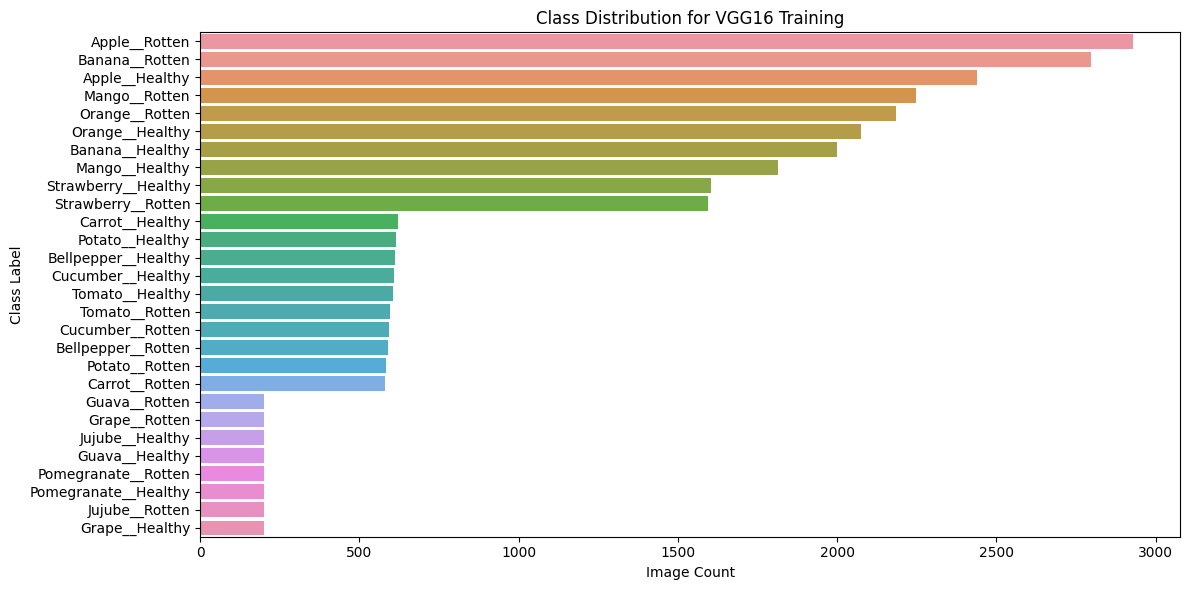

Phase 2 completed.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

DATASET_PATH = Path("/kaggle/working/cleaned_dataset/")

def get_image_dataframe(dataset_path: Path) -> pd.DataFrame:
    data = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_path = os.path.join(root, file)
                label = os.path.basename(root)
                data.append((full_path, label))
    df = pd.DataFrame(data, columns=["filepath", "label"])
    if df.empty:
        raise RuntimeError(f"No images found under {dataset_path}. Did Phase 0 run?")
    print(f"Total images: {len(df)}")
    print(f"Total classes: {df['label'].nunique()}")
    return df

def plot_class_distribution(df: pd.DataFrame):
    plt.figure(figsize=(12, 6))
    sns.countplot(y='label', data=df, order=df['label'].value_counts().index)
    plt.title("Class Distribution for VGG16 Training")
    plt.xlabel("Image Count")
    plt.ylabel("Class Label")
    plt.tight_layout()
    plt.show()
    plt.close()

# Run Phase 2
print("Phase 2: Starting EDA for VGG16...")
df_images = get_image_dataframe(DATASET_PATH)
print("\nPer-class counts:")
print(df_images['label'].value_counts().sort_index())

plot_class_distribution(df_images)
print("Phase 2 completed.")


# Phase 3 - Cross-Validation Splits (Enhanced from original)

In [4]:
from sklearn.model_selection import train_test_split, StratifiedKFold

# Paths
OUTPUT_SPLIT_DIR = Path("/kaggle/working/splits/")
OUTPUT_SPLIT_DIR.mkdir(parents=True, exist_ok=True)

# Split configuration from hyperparams
TEST_SIZE = hyperparams['test_split']
CV_FOLDS = hyperparams['cv_folds']
SEED = 42

def get_image_class_dataframe(dataset_path: Path) -> pd.DataFrame:
    data = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_path = os.path.join(root, file)
                label = os.path.basename(root)
                data.append((full_path, label))
    df = pd.DataFrame(data, columns=["filepath", "label"])
    if df.empty:
        raise RuntimeError(f"No images found under {dataset_path}. Did Phase 0 run?")
    # Stable order for reproducible splits
    df = df.sort_values("filepath").reset_index(drop=True)
    print(f"Found {len(df)} images in {df['label'].nunique()} classes")
    return df

def create_cv_splits_with_test(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Create: 1) Final test set (20%), 2) Cross-validation splits on remaining 80%
    """
    # Validate for stratification
    class_counts = df['label'].value_counts()
    min_samples = class_counts.min()
    
    if min_samples < CV_FOLDS + 1:
        raise ValueError(f"Insufficient samples for {CV_FOLDS}-fold CV. "
                        f"Minimum class has {min_samples} samples, need at least {CV_FOLDS + 1}")
    
    print(f"Creating {CV_FOLDS}-fold CV with {TEST_SIZE:.0%} test holdout for VGG16...")
    
    # First split: separate test set
    df_train_val, df_test = train_test_split(
        df,
        test_size=TEST_SIZE,
        stratify=df['label'],
        random_state=SEED,
        shuffle=True
    )
    
    print(f"Final test set: {len(df_test)} images ({len(df_test)/len(df):.1%})")
    print(f"Train+Val set: {len(df_train_val)} images ({len(df_train_val)/len(df):.1%})")
    
    # Create K-fold splits on train_val data
    skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=SEED)
    cv_splits = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(df_train_val, df_train_val['label'])):
        train_data = df_train_val.iloc[train_idx].reset_index(drop=True)
        val_data = df_train_val.iloc[val_idx].reset_index(drop=True)
        
        cv_splits.append({
            'fold': fold_idx,
            'train': train_data,
            'val': val_data
        })
        
        print(f"Fold {fold_idx + 1}: Train={len(train_data)}, Val={len(val_data)}")
    
    return {
        'test_set': df_test.reset_index(drop=True),
        'cv_splits': cv_splits,
        'metadata': {
            'total_samples': len(df),
            'test_samples': len(df_test),
            'cv_samples': len(df_train_val),
            'num_folds': CV_FOLDS,
            'num_classes': df['label'].nunique(),
            'class_names': sorted(df['label'].unique())
        }
    }

# Run Phase 3
print("Phase 3: Starting cross-validation dataset split for VGG16")
df_all = get_image_class_dataframe(DATASET_PATH)
splits_data = create_cv_splits_with_test(df_all)

# Save test set for final evaluation
test_csv_path = OUTPUT_SPLIT_DIR / "test_split.csv"
splits_data['test_set'].to_csv(test_csv_path, index=False)
print(f"Test set saved to: {test_csv_path}")

print("Phase 3 completed successfully.")


Phase 3: Starting cross-validation dataset split for VGG16
Found 29284 images in 28 classes
Creating 5-fold CV with 20% test holdout for VGG16...
Final test set: 5857 images (20.0%)
Train+Val set: 23427 images (80.0%)
Fold 1: Train=18741, Val=4686
Fold 2: Train=18741, Val=4686
Fold 3: Train=18742, Val=4685
Fold 4: Train=18742, Val=4685
Fold 5: Train=18742, Val=4685
Test set saved to: /kaggle/working/splits/test_split.csv
Phase 3 completed successfully.


# Phase 4 - tf.data pipeline (Cross-validation ready)

In [5]:
import json
import tensorflow as tf
from tensorflow.keras import layers

# Constants from hyperparams
BATCH_SIZE = hyperparams['batch_size']
IMAGE_SIZE = hyperparams['image_size'][:2]
AUTOTUNE = tf.data.AUTOTUNE

# Create stable class mapping from all data
def build_class_mapping(class_names):
    """Build stable class mapping with TensorFlow lookup table"""
    class_to_idx = {name: idx for idx, name in enumerate(sorted(class_names))}
    idx_to_class = [name for name, _ in sorted(class_to_idx.items(), key=lambda x: x[1])]
    
    # Create TensorFlow lookup table
    keys_tensor = tf.constant(list(class_to_idx.keys()))
    vals_tensor = tf.constant(list(class_to_idx.values()), dtype=tf.int64)
    table_init = tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor)
    lookup_table = tf.lookup.StaticHashTable(table_init, default_value=-1)
    
    return {
        'class_to_idx': class_to_idx,
        'idx_to_class': idx_to_class,
        'lookup_table': lookup_table,
        'num_classes': len(class_names)
    }

# Build class mapping
class_mapping = build_class_mapping(splits_data['metadata']['class_names'])
NUM_CLASSES = class_mapping['num_classes']

@tf.function
def decode_image_vgg16(filename: tf.Tensor, label_str: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    """VGG16-specific image decoding with proper preprocessing pipeline"""
    img_raw = tf.io.read_file(filename)
    
    # Decode based on extension
    def decode_jpeg():
        return tf.image.decode_jpeg(img_raw, channels=3)
    
    def decode_png():
        return tf.image.decode_png(img_raw, channels=3)
    
    # Get extension
    ext = tf.strings.lower(tf.strings.split(filename, '.')[-1])
    img = tf.cond(
        tf.logical_or(tf.equal(ext, 'jpg'), tf.equal(ext, 'jpeg')),
        decode_jpeg,
        decode_png
    )
    
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, IMAGE_SIZE, method=tf.image.ResizeMethod.BILINEAR)
    img = tf.clip_by_value(img, 0, 255)
    
    # Keep in [0,255] range for VGG16 preprocessing
    img = tf.cast(img, tf.float32)

    label_id = class_mapping['lookup_table'].lookup(label_str)
    label_id = tf.where(label_id < 0, tf.zeros_like(label_id), label_id)
    one_hot = tf.one_hot(label_id, depth=NUM_CLASSES)
    return img, one_hot

@tf.function
def augment_image_vgg16(image: tf.Tensor, label: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    """VGG16-appropriate augmentation (more conservative due to larger model)"""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.08)
    image = tf.image.random_contrast(image, 0.92, 1.08)
    # Additional rotation for VGG16 robustness
    image = tf.image.rot90(image, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
    return image, label

def build_dataset_vgg16(df: pd.DataFrame, is_training: bool = True) -> tf.data.Dataset:
    """Build tf.data.Dataset from DataFrame optimized for VGG16"""
    filepaths = df['filepath'].values
    labels = df['label'].values
    
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    
    if is_training:
        ds = ds.shuffle(hyperparams['shuffle_buffer_size'], reshuffle_each_iteration=True)
    
    ds = ds.map(decode_image_vgg16, num_parallel_calls=AUTOTUNE)
    
    if is_training:
        ds = ds.map(augment_image_vgg16, num_parallel_calls=AUTOTUNE)
    
    ds = ds.batch(BATCH_SIZE, drop_remainder=False)
    ds = ds.apply(tf.data.experimental.ignore_errors())
    ds = ds.prefetch(AUTOTUNE)
    return ds

def get_class_names():
    return class_mapping['idx_to_class']

print("Phase 4: tf.data pipeline ready for VGG16 cross-validation")
print(f"Number of classes: {NUM_CLASSES}")
print(f"VGG16 batch size: {BATCH_SIZE}")
print("Phase 4 completed.")


Phase 4: tf.data pipeline ready for VGG16 cross-validation
Number of classes: 28
VGG16 batch size: 24
Phase 4 completed.


I0000 00:00:1756362469.738704      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756362469.739601      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Phase 5 - VGG16 Model Builder

In [6]:
# Import necessary modules from TensorFlow Keras
from tensorflow.keras import layers, models

def create_vgg16_model(
    input_shape=(224, 224, 3),        # Standard ImageNet input size: 224x224 pixels, 3 color channels (RGB)
    num_classes: int = 28,            # Number of output classes for classification (e.g., 28 letters in alphabet)
    dropout_rate: float = 0.4,        # Probability of neurons being dropped during training (prevents overfitting)
    trainable_backbone: bool = True,   # Whether to allow VGG16 weights to be updated during training
    unfreeze_last_n: int = None,      # Number of last layers to make trainable (for fine-tuning)
    add_batch_norm: bool = True,      # Whether to add BatchNormalization layers (helps with training stability)
    freeze_batch_norm: bool = True    # Whether to freeze BatchNorm layers during training
) -> tf.keras.Model:                  # Function returns a Keras Model object
    """
    VGG16 classifier with fine-tuning controls and optional batch normalization.
    VGG16-specific preprocessing and architecture considerations.
    """
    inputs = layers.Input(shape=input_shape, name="input_image")      # Create input layer that accepts images of specified shape
    
    x = layers.Lambda(tf.keras.applications.vgg16.preprocess_input,   # VGG16 preprocessing expects images in [0,255] range
                      name="vgg16_preproc")(inputs)

    # Load pre-trained VGG16 backbone 
    base = tf.keras.applications.VGG16(
        input_shape=input_shape,           # Input dimensions must match our data
        include_top=False,                 # Don't include the final classification layers 
        weights="imagenet",                # Use weights pre-trained on ImageNet dataset
    )
    base._name = "vgg16_base"              # Give the base model a descriptive name
    base.trainable = trainable_backbone    # Set whether the backbone can be trained
    
    # VGG16-specific fine-tuning strategy
    if trainable_backbone and unfreeze_last_n is not None:
        
        for layer in base.layers:          # Freeze all layers first
            layer.trainable = False
        
        for layer in base.layers[-unfreeze_last_n:]:                    # Unfreeze last N layers (VGG16 has ~19 layers total)
            layer.trainable = True
            
        print(f"VGG16: Unfroze last {unfreeze_last_n} layers out of {len(base.layers)} total")

    x = base(x)                                                         # Apply the VGG16 base model to our preprocessed input
    x = layers.GlobalAveragePooling2D(name="gap")(x)                    # Global Average Pooling
    
    if add_batch_norm:                                                  # Add batch normalization if requested (VGG16 doesn't have built-in BatchNorm)
        x = layers.BatchNormalization(name="bn_after_gap")(x)
    
    x = layers.Dropout(dropout_rate, name="dropout1")(x)                # First dropout layer
    
    x = layers.Dense(1024, activation="relu", name="dense_intermediate")(x)     # Additional dense layer for VGG16's larger feature space
    
    if add_batch_norm:                                                 # Add another batch normalization layer if requested
        x = layers.BatchNormalization(name="bn_intermediate")(x)
    
    x = layers.Dropout(dropout_rate * 0.5, name="dropout2")(x)         # Add another batch normalization layer if requested
    
    outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)    # Softmax activation ensures outputs sum to 1

    model = models.Model(inputs, outputs, name="vgg16_finetune")       # Create the complete model by connecting inputs to outputs
    
    # Print model summary for VGG16
    print(f"VGG16 model created with {model.count_params():,} parameters")
    print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")
    
    return model

print("Phase 5: VGG16 model builder ready")
print("VGG16-specific features:")
print("- VGG16 preprocessing pipeline")
print("- Optional batch normalization layers")
print("- Two-stage dropout strategy")
print("- Intermediate dense layer for feature refinement")
print("Phase 5 completed.")


Phase 5: VGG16 model builder ready
VGG16-specific features:
- VGG16 preprocessing pipeline
- Optional batch normalization layers
- Two-stage dropout strategy
- Intermediate dense layer for feature refinement
Phase 5 completed.


# Phase 6 -  Cross-Validation Training (VGG16-optimized)

In [7]:
# Import necessary libraries
from tensorflow.keras import callbacks
from tensorflow.keras.losses import CategoricalCrossentropy

# Enable mixed precision if configured
if hyperparams.get('use_mixed_precision', True):                  # Check if mixed precision is enabled in hyperparameters
    tf.keras.mixed_precision.set_global_policy('mixed_float16')   # Set global policy to use 16-bit floats
    print("Mixed precision enabled (float16) for VGG16.")         # Confirmation message

# Pull VGG16-specific hyperparams
EPOCHS1 = hyperparams['epochs_stage1']                            # Number of epochs for stage 1 (frozen backbone)
EPOCHS2 = hyperparams['epochs_stage2']                            # Number of epochs for stage 2 (fine-tuning)
LR1 = hyperparams['learning_rate_stage1']                         # Learning rate for stage 1 (usually higher)
LR2 = hyperparams['learning_rate_stage2']                         # Learning rate for stage 2 (usually lower for fine-tuning)
DROPOUT = hyperparams['dropout_rate']                             # Dropout probability to prevent overfitting
UNFREEZE_N = hyperparams['vgg16_unfreeze_layers']                 # How many top layers to unfreeze in stage 2
ADD_BN = hyperparams['vgg16_add_batch_norm']                      # Whether to add batch normalization layers

# Output paths
CKPT_DIR = Path("/kaggle/working/checkpoints/")                   # Directory for saving model checkpoints
LOG_DIR = Path("/kaggle/working/logs/")                           # Directory for training logs 
MODEL_DIR = Path("/kaggle/working/models/")                       # Directory for final trained models
for p in (CKPT_DIR, LOG_DIR, MODEL_DIR):                          # Create directories if they don't exist
    p.mkdir(parents=True, exist_ok=True)

def make_callbacks_vgg16(fold_idx: int, stage: str):
    """Create callbacks optimized for VGG16 training"""
    # Create fold-specific checkpoint directory
    fold_ckpt_dir = CKPT_DIR / f"vgg16_fold_{fold_idx}"          # Path for this fold's checkpoints
    fold_ckpt_dir.mkdir(parents=True, exist_ok=True)             # Create the directory
    
    
    return [
        # Early Stopping
        callbacks.EarlyStopping(
            monitor="val_accuracy",                           # Metric to monitor
            patience=hyperparams['early_stopping_patience'],  # How many epochs to wait before stopping
            mode="max",                                       # We want to maximize accuracy
            restore_best_weights=True,                        # Restore weights from best epoch when stopping
            verbose=1                                         # Print messages when stopping
        ),
        # Reduce Learning Rate on Plateau
        callbacks.ReduceLROnPlateau(
            monitor="val_accuracy",                           # Metric to monitor
            factor=0.5,                                       # Multiply LR by this factor when reducing
            patience=hyperparams['reduce_lr_patience'],       # Wait this many epochs before reducing
            mode="max",                                       # We want to maximize accuracy
            verbose=1,                                        # Print messages when reducing LR
            min_lr=1e-7                                       # Don't reduce LR below this value
        ),
        # Model Checkpoint
        callbacks.ModelCheckpoint(
            str(fold_ckpt_dir / f"vgg16_best_{stage}.h5"),    # File path to save model
            monitor="val_accuracy",                           # Metric to monitor for "best" model
            save_best_only=True,                              # Only save when validation accuracy improves
            save_weights_only=False,                          # Save entire model, not just weights
            mode="max",                                       # We want to maximize accuracy
            verbose=1                                         # Print messages when saving
        )
    ]

def train_single_fold_vgg16(fold_data, fold_idx):
    """Train a single fold with VGG16-specific two-stage approach"""
    print(f"\n{'='*60}")                                                           # Print separator line
    print(f"Training VGG16 Fold {fold_idx + 1}/{len(splits_data['cv_splits'])}")   # Current fold info
    print(f"{'='*60}")                                                             # Print separator line
    
    # Create datasets for this fold
    train_ds = build_dataset_vgg16(fold_data['train'], is_training=True)           # Training data with augmentation
    val_ds = build_dataset_vgg16(fold_data['val'], is_training=False)              # Validation data without augmentation
    
    # Create VGG16 model
    model = create_vgg16_model(
        input_shape=hyperparams['image_size'],                 # Input image dimensions (height, width, channels)
        num_classes=NUM_CLASSES,                               # Number of output classes for classification
        dropout_rate=DROPOUT,                                  # Dropout rate in classifier head
        trainable_backbone=False,                              # Stage 1: keep backbone frozen
        add_batch_norm=ADD_BN                                  # Whether to add batch normalization
    )
    
    # Stage 1: frozen backbone training
    print("Stage 1: Training VGG16 with frozen backbone...")
    optimizer_1 = tf.keras.optimizers.Adam(learning_rate=LR1)     # Create optimizer for stage 1
    model.compile(                                                # Compile the model with optimizer, loss, and metrics
        optimizer=optimizer_1,                                    # Optimizer for gradient descent
        loss=CategoricalCrossentropy(label_smoothing=0.1),        # Loss function with label smoothing
        metrics=["accuracy"]                                      # Track accuracy during training
    )
    
    # Warm-up prediction for memory allocation
    for sample_batch in train_ds.take(1):                         # Get one batch from training data
        _ = model.predict(sample_batch[0][:4], verbose=0)         # Make prediction on first 4 samples
        break  # Exit after one batch
    
    # Train the model for stage 1
    history_1 = model.fit(
        train_ds,                                                 # Training dataset
        validation_data=val_ds,                                   # Validation dataset
        epochs=EPOCHS1,                                           # Number of epochs for stage 1
        callbacks=make_callbacks_vgg16(fold_idx, "stage1"),       # Callbacks for this stage
        verbose=1                                                 # Print progress during training
    )
    
    # Stage 2: VGG16 fine-tuning
    print(f"Stage 2: Fine-tuning VGG16 with last {UNFREEZE_N} layers unfrozen...")
    try:
        base = model.get_layer("vgg16_base")             # Get the VGG16 base model (backbone)
        
        for layer in base.layers:                        # VGG16-specific layer unfreezing
            layer.trainable = False
        
        for layer in base.layers[-UNFREEZE_N:]:          # Unfreeze last N layers
            layer.trainable = True
            
        print(f"VGG16: Unfroze {sum([l.trainable for l in base.layers])} layers out of {len(base.layers)}")
        
    except Exception as e:
        # Fallback: if layer access fails, unfreeze entire model
        print(f"Fallback: unfroze entire VGG16 model due to error: {e}")
        for layer in model.layers:                             # Iterate through all model layers
            layer.trainable = True                             # Make all layers trainable
    
    optimizer_2 = tf.keras.optimizers.Adam(learning_rate=LR2)  # Create optimizer for stage 2 with lower learning rate
    model.compile(
        optimizer=optimizer_2,                                 # New optimizer with lower learning rate
        loss=CategoricalCrossentropy(label_smoothing=0.1),     # Same loss function
        metrics=["accuracy"]                                   # Same metrics
    )
    
    # Train the model for stage 2 (fine-tuning)
    history_2 = model.fit(
        train_ds,                                             # Same training dataset
        validation_data=val_ds,                               # Same validation dataset
        epochs=EPOCHS2,                                       # Number of epochs for stage 2
        callbacks=make_callbacks_vgg16(fold_idx, "stage2"),   # Callbacks for this stage
        verbose=1                                             # Print progress during training
    )
    
    # Evaluate
    val_metrics = model.evaluate(val_ds, verbose=0)
    val_accuracy = val_metrics[1]
    
    print(f"VGG16 Fold {fold_idx + 1} Final Validation Accuracy: {val_accuracy:.4f}")
    
    # Return all important information about this fold's training
    return {
        'fold': fold_idx,                               # Fold index
        'val_accuracy': val_accuracy,                   # Final validation accuracy
        'val_loss': val_metrics[0],                     # Final validation loss
        'model': model,                                 # Trained model
        'history': {                                    # Training history from both stages
            'stage1': history_1.history,                # Stage 1 training metrics
            'stage2': history_2.history                 # Stage 2 training metrics
        }
    }

# Run cross-validation for VGG16
print("Starting VGG16 Cross-Validation Training...")
cv_results = []  # Store results from each fold
all_models = []  # Store trained models from each fold

# Train on each fold
for fold_idx, fold_data in enumerate(splits_data['cv_splits']):  # Loop through CV folds
    fold_result = train_single_fold_vgg16(fold_data, fold_idx)   # Train this fold
    cv_results.append(fold_result)                               # Store fold results
    all_models.append(fold_result['model'])                      # Store trained model
    
    # Clean up memory after each fold to prevent OOM errors
    tf.keras.backend.clear_session()      # Clear TensorFlow session and free GPU memory

# Calculate CV statistics
fold_accuracies = [result['val_accuracy'] for result in cv_results]
cv_mean = np.mean(fold_accuracies)        # Average accuracy across folds
cv_std = np.std(fold_accuracies)          # Standard deviation of accuracies

print(f"\n{'='*60}")
print(f"VGG16 Cross-Validation Results Summary")
print(f"{'='*60}")
print(f"Mean Accuracy: {cv_mean:.4f} ± {cv_std:.4f}")
print(f"Individual folds: {[f'{acc:.4f}' for acc in fold_accuracies]}")
print(f"Best fold: {max(fold_accuracies):.4f}")
print(f"Worst fold: {min(fold_accuracies):.4f}")

print("VGG16 Cross-Validation Training completed.")


Mixed precision enabled (float16) for VGG16.
Starting VGG16 Cross-Validation Training...

Training VGG16 Fold 1/5
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG16 model created with 15,274,844 parameters
Trainable parameters: 557,084
Stage 1: Training VGG16 with frozen backbone...


I0000 00:00:1756362499.826900      86 service.cc:148] XLA service 0x7ab0d4004ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756362499.827618      86 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756362499.827636      86 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756362499.991314      86 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 1/8


I0000 00:00:1756362503.417862      86 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    780/Unknown 92s 99ms/step - accuracy: 0.6527 - loss: 1.8651

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.92360, saving model to /kaggle/working/checkpoints/vgg16_fold_0/vgg16_best_stage1.h5
780/780 ━━━━━━━━━━━━━━━━━━━━ 107s 118ms/step - accuracy: 0.6529 - loss: 1.8646 - val_accuracy: 0.9236 - val_loss: 0.9929 - learning_rate: 8.0000e-04
Epoch 2/8
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8611 - loss: 1.1428
Epoch 2: val_accuracy improved from 0.92360 to 0.93705, saving model to /kaggle/working/checkpoints/vgg16_fold_0/vgg16_best_stage1.h5
780/780 ━━━━━━━━━━━━━━━━━━━━ 74s 94ms/step - accuracy: 0.8611 - loss: 1.1427 - val_accuracy: 0.9370 - val_loss: 0.9199 - learning_rate: 8.0000e-04
Epoch 3/8
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8818 - loss: 1.0648
Epoch 3: val_accuracy improved from 0.93705 to 0.94814, saving model to /kaggle/working/checkpoints/vgg16_fold_0/vgg16_best_stage1.h5
780/780 ━━━━━━━━━━━━━━━━━━━━ 73s 94ms/step - accuracy: 0.8818 - loss: 1.0647 - val_accuracy: 0.9481 - val_loss: 0.8863 - learning_ra

2025-08-28 06:39:07.933502: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[24,112,112,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[24,112,112,128]{3,2,1,0}, f16[128,3,3,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-08-28 06:39:12.208770: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 5.275449081s
Trying algorithm eng0{} for conv (f16[24,112,112,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[24,112,112,128]{3,2,1,0}, f16[128,3,3,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config"

    779/Unknown 412s 124ms/step - accuracy: 0.9375 - loss: 0.9067

2025-08-28 06:45:50.823441: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[21,112,112,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[21,112,112,128]{3,2,1,0}, f16[128,3,3,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-08-28 06:45:54.376963: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 4.553575149s
Trying algorithm eng0{} for conv (f16[21,112,112,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[21,112,112,128]{3,2,1,0}, f16[128,3,3,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config"

    780/Unknown 694s 486ms/step - accuracy: 0.9376 - loss: 0.9067
Epoch 1: val_accuracy improved from -inf to 0.97396, saving model to /kaggle/working/checkpoints/vgg16_fold_0/vgg16_best_stage2.h5
780/780 ━━━━━━━━━━━━━━━━━━━━ 705s 500ms/step - accuracy: 0.9376 - loss: 0.9067 - val_accuracy: 0.9740 - val_loss: 0.7961 - learning_rate: 5.0000e-06
Epoch 2/18
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9591 - loss: 0.8572
Epoch 2: val_accuracy improved from 0.97396 to 0.97866, saving model to /kaggle/working/checkpoints/vgg16_fold_0/vgg16_best_stage2.h5
780/780 ━━━━━━━━━━━━━━━━━━━━ 106s 136ms/step - accuracy: 0.9591 - loss: 0.8572 - val_accuracy: 0.9787 - val_loss: 0.7889 - learning_rate: 5.0000e-06
Epoch 3/18
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9663 - loss: 0.8346
Epoch 3: val_accuracy did not improve from 0.97866
780/780 ━━━━━━━━━━━━━━━━━━━━ 105s 135ms/step - accuracy: 0.9663 - loss: 0.8346 - val_accuracy: 0.9772 - val_loss: 0.7814 - learning_rate: 5.0000

# Phase 7 - Final Model Selection and Test Evaluation

In [8]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support

# Select best VGG16 model from CV
best_fold_idx = np.argmax(fold_accuracies)
best_model = cv_results[best_fold_idx]['model']
print(f"Selected best VGG16 model from fold {best_fold_idx + 1} (accuracy: {fold_accuracies[best_fold_idx]:.4f})")

# Save best VGG16 model
final_model_path = MODEL_DIR / "best_vgg16_final.h5"
best_model.save(final_model_path)
print(f"Best VGG16 model saved to: {final_model_path}")

# Evaluate on test set
print(f"\n{'='*60}")
print(f"VGG16 Final Test Set Evaluation")
print(f"{'='*60}")

test_ds = build_dataset_vgg16(splits_data['test_set'], is_training=False)

# Collect predictions on test set
y_true_idx = []
y_pred_probs = []

print("Collecting VGG16 predictions on test set...")
for batch_imgs, batch_labels in test_ds:
    y_true_idx.extend(tf.argmax(batch_labels, axis=-1).numpy())
    preds = best_model.predict(batch_imgs, verbose=0)
    y_pred_probs.extend(preds)

y_true_idx = np.array(y_true_idx)
y_pred_probs = np.array(y_pred_probs)
y_pred_idx = np.argmax(y_pred_probs, axis=-1)

# Calculate metrics
test_accuracy = accuracy_score(y_true_idx, y_pred_idx)

# Top-k accuracies
def top_k_accuracy(y_true, y_prob, k):
    top_k_preds = np.argsort(-y_prob, axis=1)[:, :k]
    return np.mean([y_true[i] in top_k_preds[i] for i in range(len(y_true))])

top3_accuracy = top_k_accuracy(y_true_idx, y_pred_probs, 3)
top5_accuracy = top_k_accuracy(y_true_idx, y_pred_probs, 5)

# Classification report
class_names = get_class_names()
clf_report = classification_report(
    y_true_idx, y_pred_idx, 
    target_names=class_names, 
    output_dict=True, 
    zero_division=0
)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_idx, y_pred_idx)

print(f"VGG16 Test Accuracy (Top-1): {test_accuracy:.4f}")
print(f"VGG16 Test Accuracy (Top-3): {top3_accuracy:.4f}")
print(f"VGG16 Test Accuracy (Top-5): {top5_accuracy:.4f}")

# Calculate precision, recall, f1-score for each class
precision, recall, f1, support = precision_recall_fscore_support(
    y_true_idx, y_pred_idx, average=None, zero_division=0
)

# Calculate macro and weighted averages
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true_idx, y_pred_idx, average='macro', zero_division=0
)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_true_idx, y_pred_idx, average='weighted', zero_division=0
)

# Create comprehensive metrics table
metrics_table = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

# Add summary rows
summary_rows = pd.DataFrame({
    'Class': ['Macro Avg', 'Weighted Avg'],
    'Precision': [precision_macro, precision_weighted],
    'Recall': [recall_macro, recall_weighted],
    'F1-Score': [f1_macro, f1_weighted],
    'Support': [np.sum(support), np.sum(support)]
})

metrics_table = pd.concat([metrics_table, summary_rows], ignore_index=True)

# Display table
print(f"\nVGG16 Precision, Recall, F1-Score Table:")
print("=" * 60)
print(metrics_table.round(4).to_string(index=False))

print("Phase 6 completed.")

Selected best VGG16 model from fold 1 (accuracy: 0.9878)
Best VGG16 model saved to: /kaggle/working/models/best_vgg16_final.h5

VGG16 Final Test Set Evaluation
VGG16 Test Accuracy (Top-1): 0.9859
VGG16 Test Accuracy (Top-3): 0.9988
VGG16 Test Accuracy (Top-5): 0.9993

VGG16 Precision, Recall, F1-Score Table:
               Class  Precision  Recall  F1-Score  Support
      Apple__Healthy     0.9939  0.9959    0.9949      487
       Apple__Rotten     0.9914  0.9966    0.9940      580
     Banana__Healthy     0.9975  1.0000    0.9987      394
      Banana__Rotten     1.0000  1.0000    1.0000      554
 Bellpepper__Healthy     0.9091  1.0000    0.9524      120
  Bellpepper__Rotten     0.9115  0.8803    0.8957      117
     Carrot__Healthy     0.9440  0.9752    0.9593      121
      Carrot__Rotten     0.9720  0.9043    0.9369      115
   Cucumber__Healthy     0.9677  0.9836    0.9756      122
    Cucumber__Rotten     0.9823  0.9407    0.9610      118
      Grape__Healthy     1.0000  1.0000  

# Phase 8 - Comprehensive Evaluation and Visualization

Creating VGG16 visualizations...


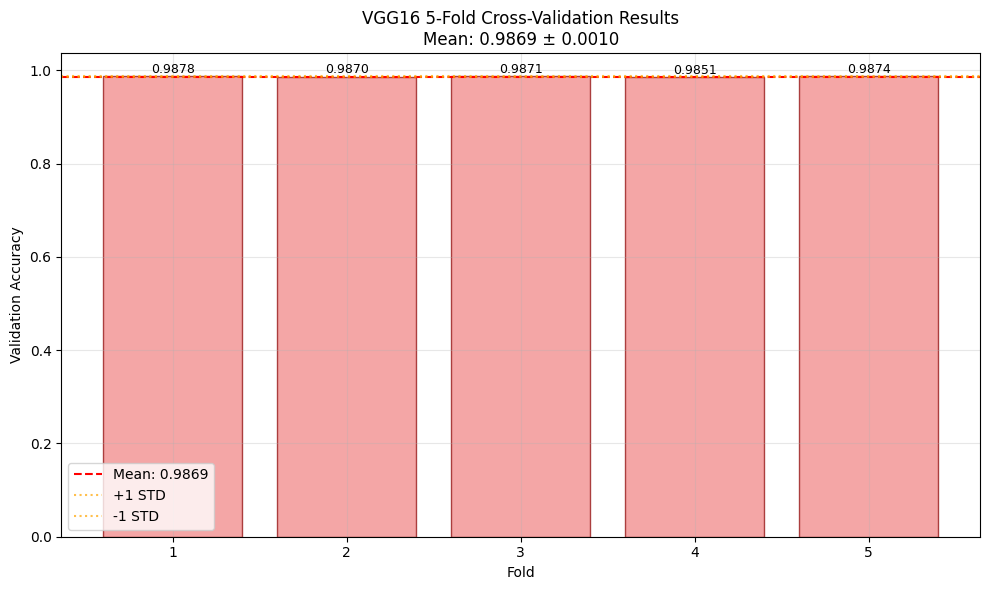

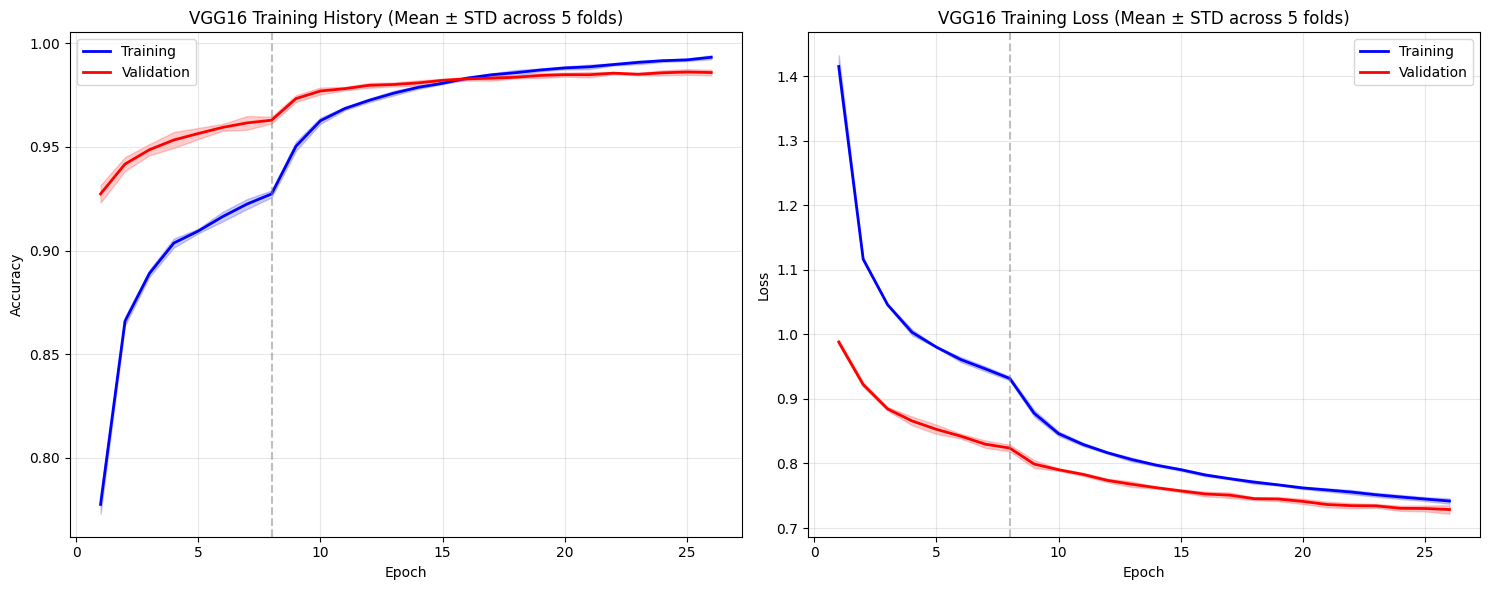

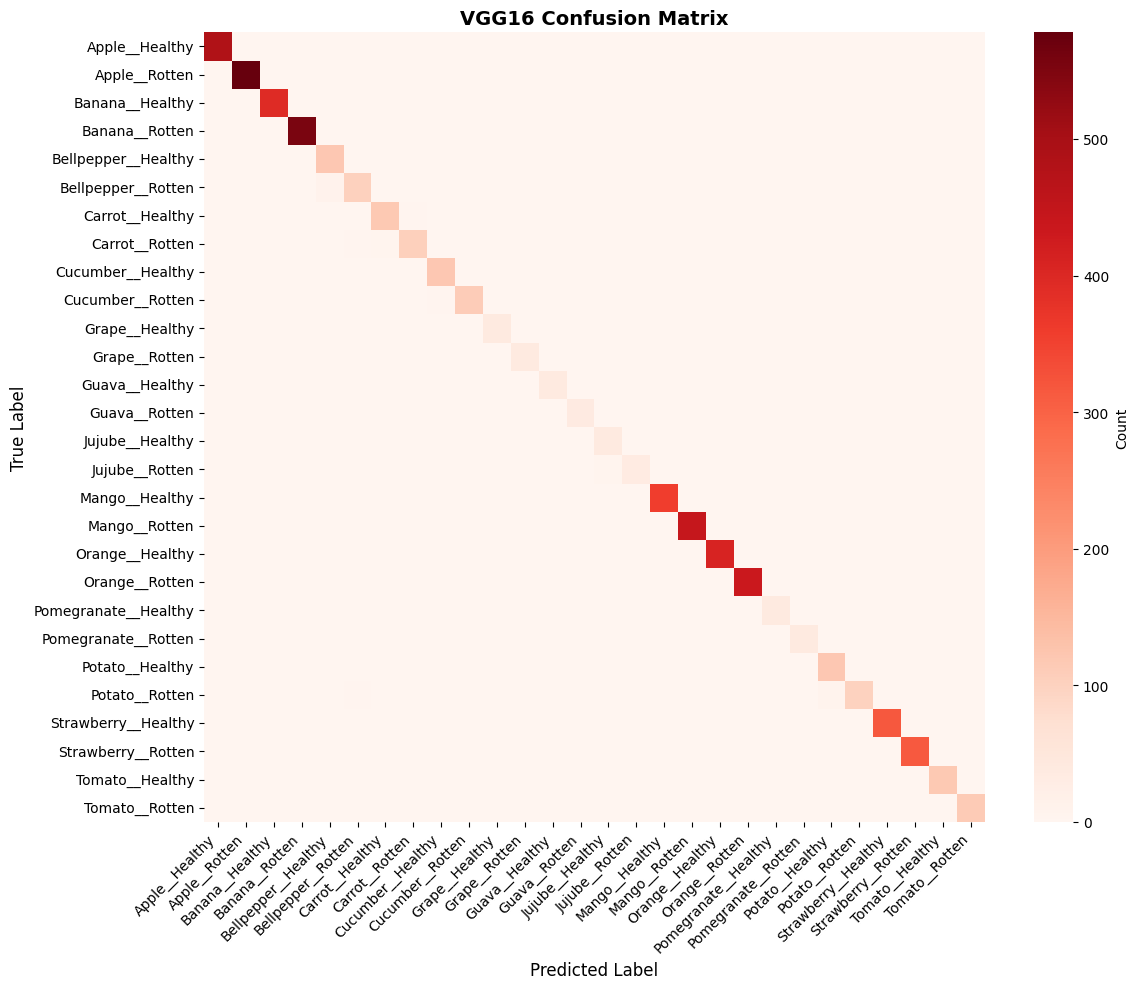

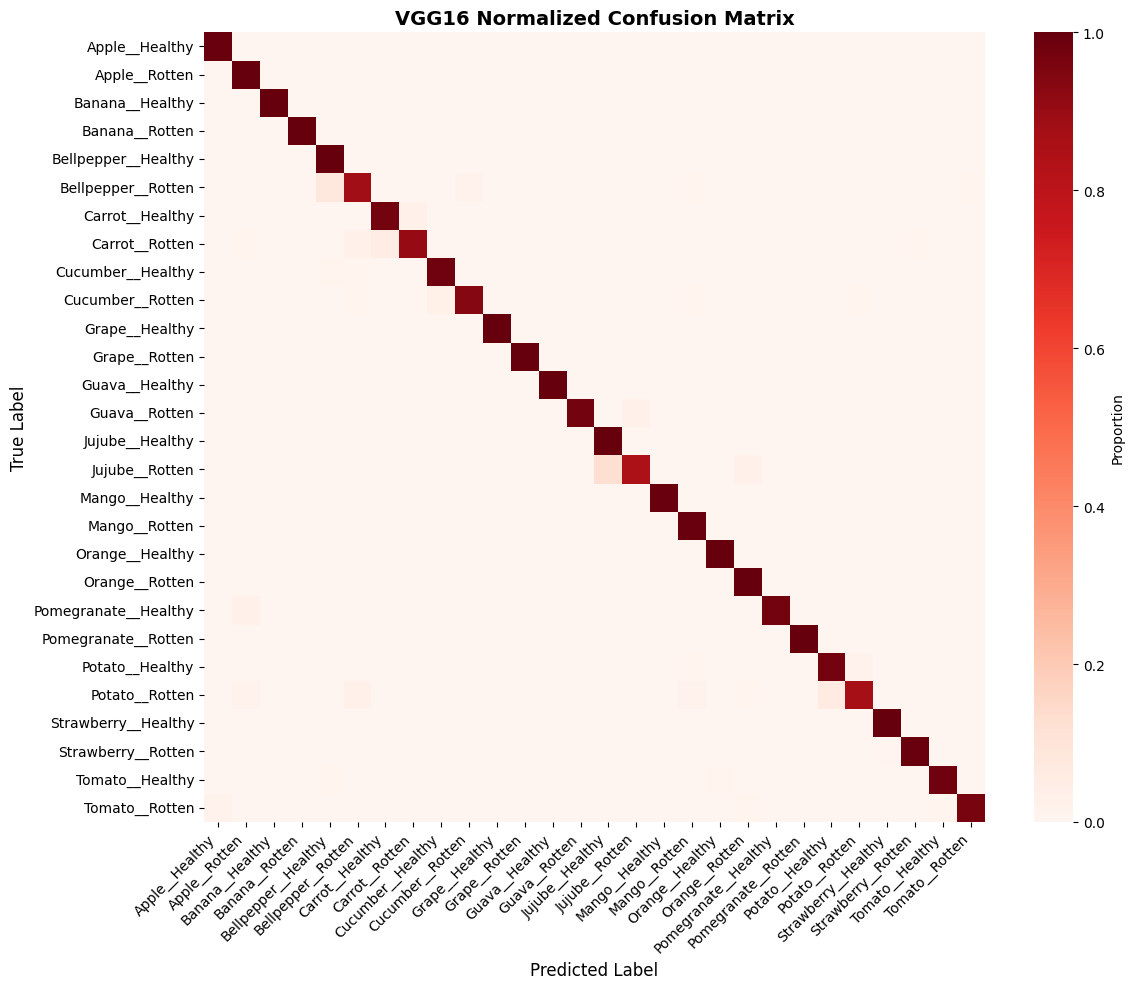

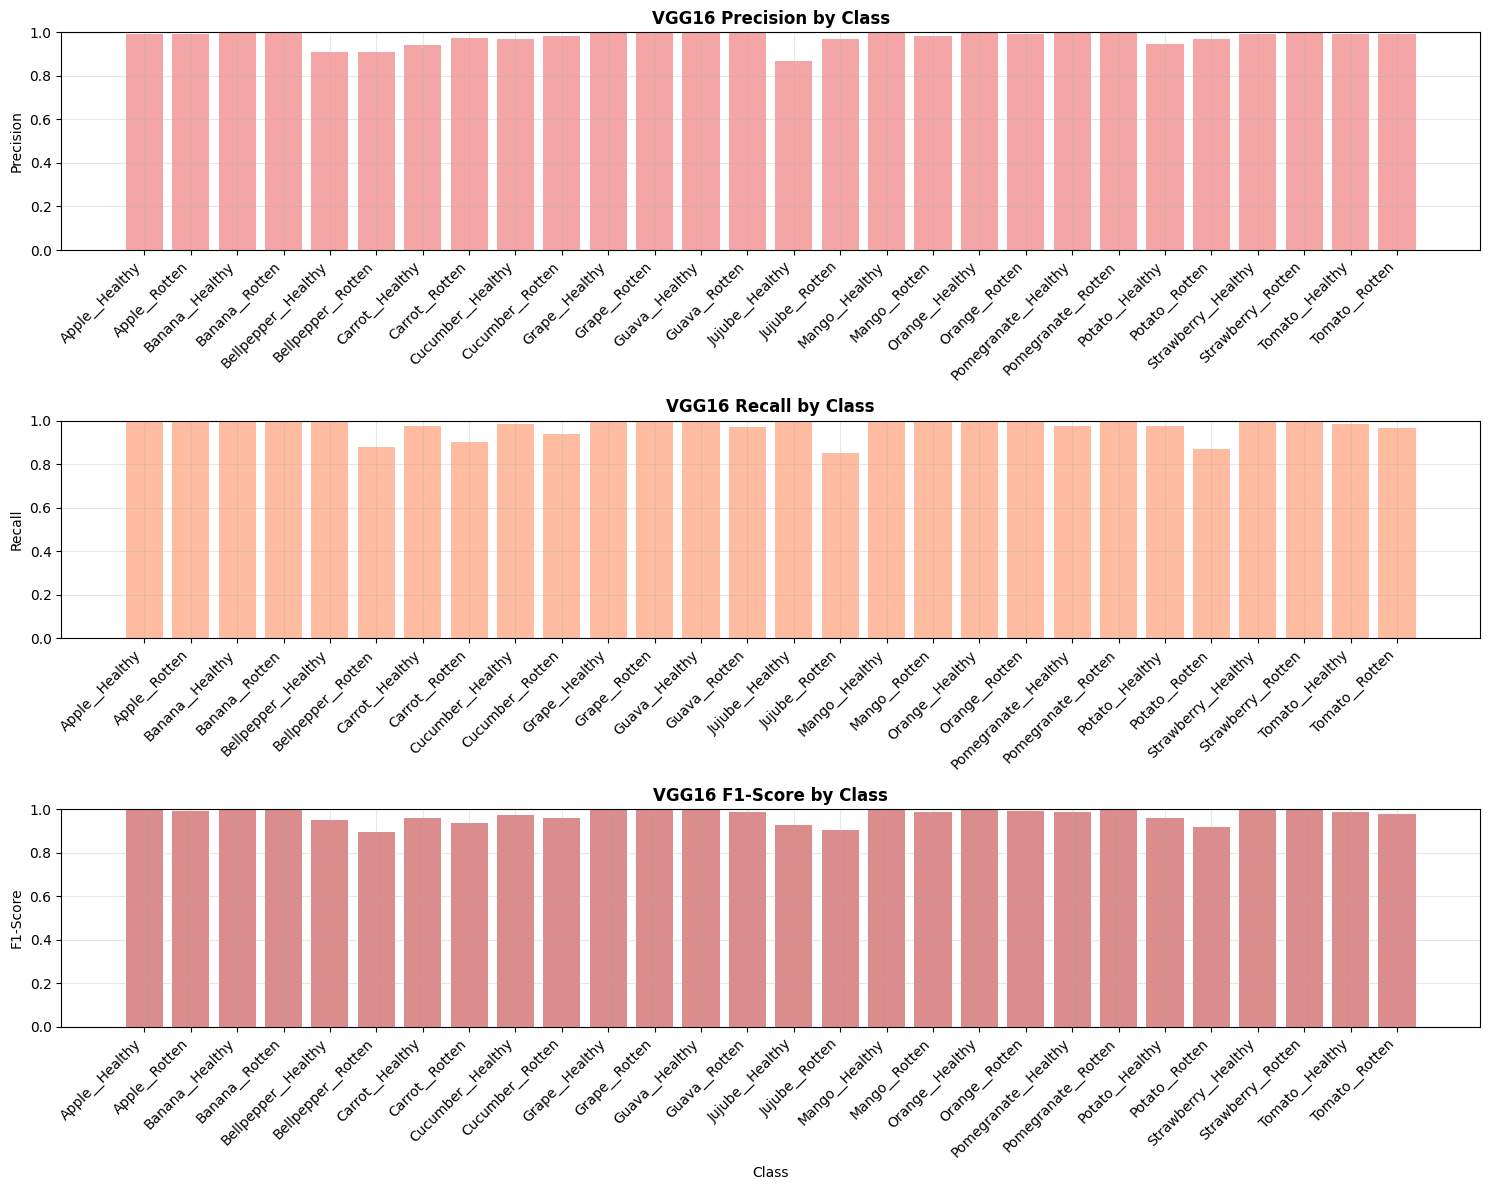

Creating additional VGG16 analysis plots...


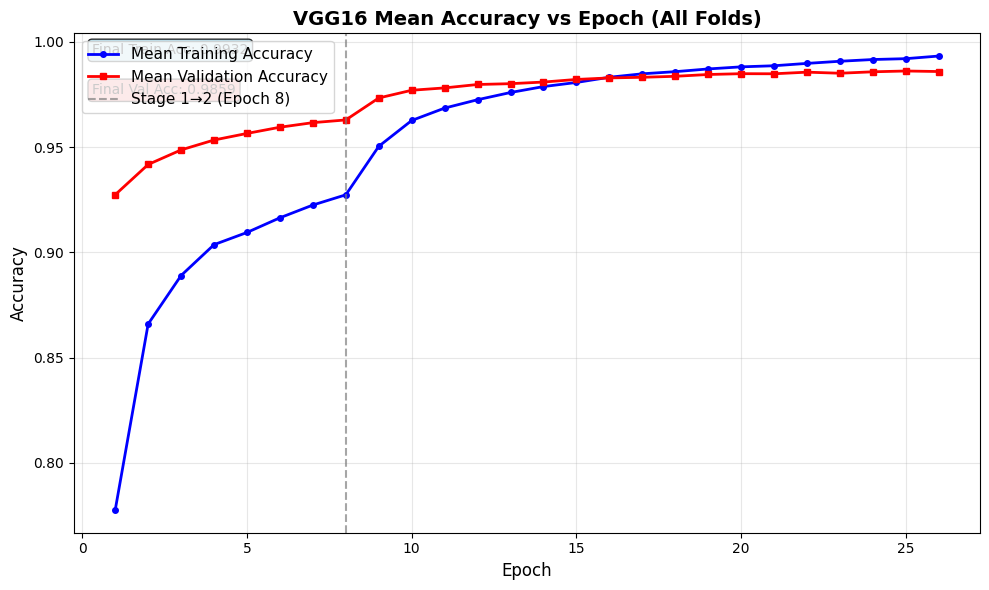

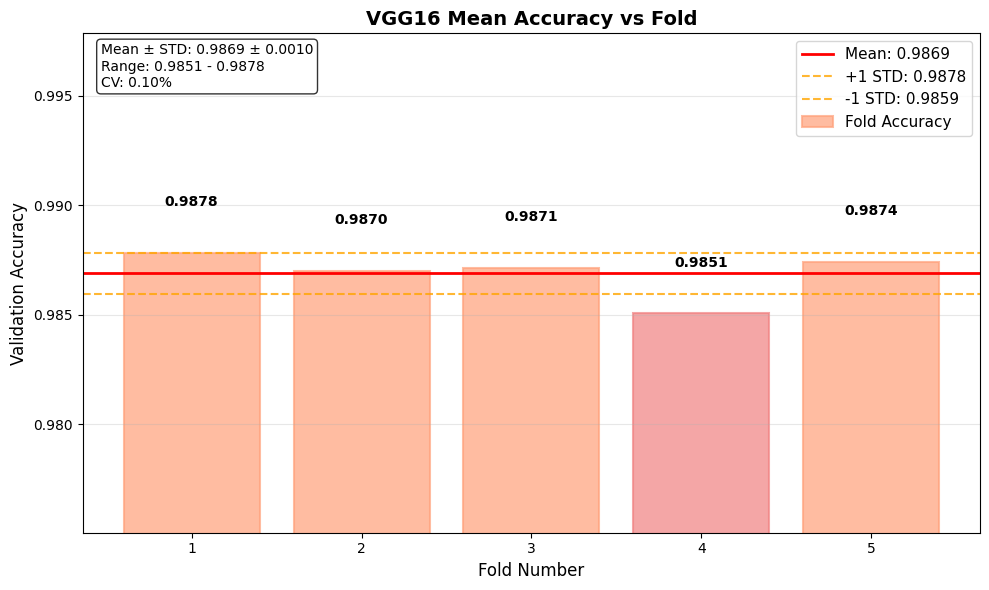

Phase 7 completed.


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create results directory for VGG16
RESULTS_DIR = Path("/kaggle/working/results/vgg16/")
PLOTS_DIR = RESULTS_DIR / "plots"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# 1. Plot VGG16 Cross-Validation Results
def plot_cv_results_vgg16():
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(1, len(fold_accuracies) + 1), fold_accuracies, 
                  alpha=0.7, color='lightcoral', edgecolor='darkred')
    plt.axhline(y=cv_mean, color='red', linestyle='--', 
               label=f"Mean: {cv_mean:.4f}")
    plt.axhline(y=cv_mean + cv_std, color='orange', linestyle=':', alpha=0.7, label=f"+1 STD")
    plt.axhline(y=cv_mean - cv_std, color='orange', linestyle=':', alpha=0.7, label=f"-1 STD")
    
    plt.xlabel('Fold')
    plt.ylabel('Validation Accuracy')
    plt.title(f'VGG16 {len(fold_accuracies)}-Fold Cross-Validation Results\n'
             f'Mean: {cv_mean:.4f} ± {cv_std:.4f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, acc) in enumerate(zip(bars, fold_accuracies)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                f'{acc:.4f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "vgg16_cv_fold_accuracies.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# 2. Plot VGG16 Training History (Combined across folds)
def plot_training_histories_vgg16():
    # Aggregate training histories across all folds
    all_train_acc = []
    all_val_acc = []
    all_train_loss = []
    all_val_loss = []
    
    max_epochs = 0
    
    for result in cv_results:
        hist = result['history']
        stage1 = hist['stage1']
        stage2 = hist['stage2']
        
        combined_train_acc = stage1.get('accuracy', []) + stage2.get('accuracy', [])
        combined_val_acc = stage1.get('val_accuracy', []) + stage2.get('val_accuracy', [])
        combined_train_loss = stage1.get('loss', []) + stage2.get('loss', [])
        combined_val_loss = stage1.get('val_loss', []) + stage2.get('val_loss', [])
        
        all_train_acc.append(combined_train_acc)
        all_val_acc.append(combined_val_acc)
        all_train_loss.append(combined_train_loss)
        all_val_loss.append(combined_val_loss)
        
        max_epochs = max(max_epochs, len(combined_train_acc))
    
    # Pad sequences and calculate mean/std
    def pad_sequence(seq, target_length):
        if len(seq) < target_length:
            return seq + [seq[-1]] * (target_length - len(seq))
        return seq[:target_length]
    
    for i in range(len(all_train_acc)):
        all_train_acc[i] = pad_sequence(all_train_acc[i], max_epochs)
        all_val_acc[i] = pad_sequence(all_val_acc[i], max_epochs)
        all_train_loss[i] = pad_sequence(all_train_loss[i], max_epochs)
        all_val_loss[i] = pad_sequence(all_val_loss[i], max_epochs)
    
    all_train_acc = np.array(all_train_acc)
    all_val_acc = np.array(all_val_acc)
    all_train_loss = np.array(all_train_loss)
    all_val_loss = np.array(all_val_loss)
    
    mean_train_acc = np.mean(all_train_acc, axis=0)
    std_train_acc = np.std(all_train_acc, axis=0)
    mean_val_acc = np.mean(all_val_acc, axis=0)
    std_val_acc = np.std(all_val_acc, axis=0)
    
    mean_train_loss = np.mean(all_train_loss, axis=0)
    std_train_loss = np.std(all_train_loss, axis=0)
    mean_val_loss = np.mean(all_val_loss, axis=0)
    std_val_loss = np.std(all_val_loss, axis=0)
    
    epochs = range(1, max_epochs + 1)
    
    plt.figure(figsize=(15, 6))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, mean_train_acc, 'b-', label='Training', linewidth=2)
    plt.fill_between(epochs, 
                    mean_train_acc - std_train_acc, 
                    mean_train_acc + std_train_acc, 
                    alpha=0.2, color='blue')
    
    plt.plot(epochs, mean_val_acc, 'r-', label='Validation', linewidth=2)
    plt.fill_between(epochs, 
                    mean_val_acc - std_val_acc, 
                    mean_val_acc + std_val_acc, 
                    alpha=0.2, color='red')
    
    plt.title(f'VGG16 Training History (Mean ± STD across {len(cv_results)} folds)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add stage separator
    stage1_epochs = EPOCHS1
    plt.axvline(x=stage1_epochs, color='gray', linestyle='--', alpha=0.5)
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mean_train_loss, 'b-', label='Training', linewidth=2)
    plt.fill_between(epochs, 
                    mean_train_loss - std_train_loss, 
                    mean_train_loss + std_train_loss, 
                    alpha=0.2, color='blue')
    
    plt.plot(epochs, mean_val_loss, 'r-', label='Validation', linewidth=2)
    plt.fill_between(epochs, 
                    mean_val_loss - std_val_loss, 
                    mean_val_loss + std_val_loss, 
                    alpha=0.2, color='red')
    
    plt.title(f'VGG16 Training Loss (Mean ± STD across {len(cv_results)} folds)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axvline(x=stage1_epochs, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "vgg16_cv_training_history.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# 3. Plot VGG16 Confusion Matrix
def plot_confusion_matrix_vgg16(normalize=False):
    if normalize:
        cm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        title = 'VGG16 Normalized Confusion Matrix'
        fmt = '.2f'
        filename = 'vgg16_confusion_matrix_normalized.png'
    else:
        cm = conf_matrix
        title = 'VGG16 Confusion Matrix'
        fmt = 'd'
        filename = 'vgg16_confusion_matrix.png'
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, 
               annot=False,  # Too many classes for text
               fmt=fmt,
               cmap='Reds',
               xticklabels=class_names,
               yticklabels=class_names,
               cbar_kws={'label': 'Count' if not normalize else 'Proportion'})
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# 4. Plot VGG16 Per-Class Metrics
def plot_per_class_metrics_vgg16():
    # Extract per-class metrics
    precisions = []
    recalls = []
    f1_scores = []
    
    for class_name in class_names:
        if class_name in clf_report:
            precisions.append(clf_report[class_name]['precision'])
            recalls.append(clf_report[class_name]['recall'])
            f1_scores.append(clf_report[class_name]['f1-score'])
        else:
            precisions.append(0.0)
            recalls.append(0.0)
            f1_scores.append(0.0)
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    x_pos = np.arange(len(class_names))
    
    # Precision
    axes[0].bar(x_pos, precisions, alpha=0.7, color='lightcoral')
    axes[0].set_title('VGG16 Precision by Class', fontweight='bold')
    axes[0].set_ylabel('Precision')
    axes[0].set_ylim(0, 1)
    axes[0].grid(True, alpha=0.3)
    
    # Recall
    axes[1].bar(x_pos, recalls, alpha=0.7, color='lightsalmon')
    axes[1].set_title('VGG16 Recall by Class', fontweight='bold')
    axes[1].set_ylabel('Recall')
    axes[1].set_ylim(0, 1)
    axes[1].grid(True, alpha=0.3)
    
    # F1-Score
    axes[2].bar(x_pos, f1_scores, alpha=0.7, color='indianred')
    axes[2].set_title('VGG16 F1-Score by Class', fontweight='bold')
    axes[2].set_ylabel('F1-Score')
    axes[2].set_xlabel('Class')
    axes[2].set_ylim(0, 1)
    axes[2].grid(True, alpha=0.3)
    
    # Set x-axis labels
    for ax in axes:
        ax.set_xticks(x_pos)
        ax.set_xticklabels(class_names, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "vgg16_per_class_metrics.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# 5. Plot VGG16 Mean Accuracy vs Epoch
def plot_mean_accuracy_vs_epoch_vgg16():
    """Plot VGG16 mean accuracy across all folds vs epoch"""
    # Reuse aggregated data from training history plot
    all_train_acc = []
    all_val_acc = []
    max_epochs = 0
    
    for result in cv_results:
        hist = result['history']
        stage1 = hist['stage1']
        stage2 = hist['stage2']
        
        combined_train_acc = stage1.get('accuracy', []) + stage2.get('accuracy', [])
        combined_val_acc = stage1.get('val_accuracy', []) + stage2.get('val_accuracy', [])
        
        all_train_acc.append(combined_train_acc)
        all_val_acc.append(combined_val_acc)
        max_epochs = max(max_epochs, len(combined_train_acc))
    
    # Pad sequences
    def pad_sequence(seq, target_length):
        if len(seq) < target_length:
            return seq + [seq[-1]] * (target_length - len(seq))
        return seq[:target_length]
    
    for i in range(len(all_train_acc)):
        all_train_acc[i] = pad_sequence(all_train_acc[i], max_epochs)
        all_val_acc[i] = pad_sequence(all_val_acc[i], max_epochs)
    
    all_train_acc = np.array(all_train_acc)
    all_val_acc = np.array(all_val_acc)
    
    mean_train_acc = np.mean(all_train_acc, axis=0)
    mean_val_acc = np.mean(all_val_acc, axis=0)
    
    epochs = range(1, max_epochs + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, mean_train_acc, 'b-', label='Mean Training Accuracy', linewidth=2, marker='o', markersize=4)
    plt.plot(epochs, mean_val_acc, 'r-', label='Mean Validation Accuracy', linewidth=2, marker='s', markersize=4)
    
    plt.title('VGG16 Mean Accuracy vs Epoch (All Folds)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Add stage separator
    stage1_epochs = EPOCHS1
    plt.axvline(x=stage1_epochs, color='gray', linestyle='--', alpha=0.7, 
               label=f'Stage 1→2 (Epoch {stage1_epochs})')
    plt.legend(fontsize=11)
    
    # Add final accuracy values as text
    plt.text(0.02, 0.98, f'Final Train Acc: {mean_train_acc[-1]:.4f}', 
             transform=plt.gca().transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    plt.text(0.02, 0.90, f'Final Val Acc: {mean_val_acc[-1]:.4f}', 
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "vgg16_mean_accuracy_vs_epoch.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# 6. Plot VGG16 Mean Accuracy vs Fold
def plot_mean_accuracy_vs_fold_vgg16():
    """Plot VGG16 mean accuracy for each fold"""
    fold_numbers = range(1, len(fold_accuracies) + 1)
    
    plt.figure(figsize=(10, 6))
    
    # Bar plot with individual fold accuracies
    bars = plt.bar(fold_numbers, fold_accuracies, alpha=0.7, color='lightcoral', 
                   edgecolor='darkred', linewidth=1.5, label='Fold Accuracy')
    
    # Add mean line
    plt.axhline(y=cv_mean, color='red', linestyle='-', linewidth=2, 
               label=f'Mean: {cv_mean:.4f}')
    
    # Add std deviation lines
    plt.axhline(y=cv_mean + cv_std, color='orange', linestyle='--', alpha=0.8, 
               label=f'+1 STD: {cv_mean + cv_std:.4f}')
    plt.axhline(y=cv_mean - cv_std, color='orange', linestyle='--', alpha=0.8, 
               label=f'-1 STD: {cv_mean - cv_std:.4f}')
    
    # Add value labels on bars
    for i, (bar, acc) in enumerate(zip(bars, fold_accuracies)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
                f'{acc:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        # Color code bars based on performance relative to mean
        if acc > cv_mean + cv_std:
            bar.set_color('lightgreen')
        elif acc < cv_mean - cv_std:
            bar.set_color('lightcoral')
        else:
            bar.set_color('lightsalmon')
    
    plt.title('VGG16 Mean Accuracy vs Fold', fontsize=14, fontweight='bold')
    plt.xlabel('Fold Number', fontsize=12)
    plt.ylabel('Validation Accuracy', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Set y-axis to show reasonable range
    y_min = min(fold_accuracies) - 0.01
    y_max = max(fold_accuracies) + 0.01
    plt.ylim(y_min, y_max)
    
    # Add statistics text box
    stats_text = f'Mean ± STD: {cv_mean:.4f} ± {cv_std:.4f}\n'
    stats_text += f'Range: {min(fold_accuracies):.4f} - {max(fold_accuracies):.4f}\n'
    stats_text += f'CV: {(cv_std/cv_mean)*100:.2f}%'
    
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=10)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "vgg16_mean_accuracy_vs_fold.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Generate all VGG16 plots
print("Creating VGG16 visualizations...")
plot_cv_results_vgg16()
plot_training_histories_vgg16()
plot_confusion_matrix_vgg16(normalize=False)
plot_confusion_matrix_vgg16(normalize=True)
plot_per_class_metrics_vgg16()

print("Creating additional VGG16 analysis plots...")
plot_mean_accuracy_vs_epoch_vgg16()
plot_mean_accuracy_vs_fold_vgg16()

print("Phase 7 completed.")


# Phase 9  Results Export and Final Summary

In [11]:
import json

# Save comprehensive VGG16 results
def save_vgg16_results():
    # 1. Save CV results summary
    cv_summary = {
        'model_architecture': 'VGG16',
        'cross_validation_summary': {
            'mean_accuracy': float(cv_mean),
            'std_accuracy': float(cv_std),
            'min_accuracy': float(min(fold_accuracies)),
            'max_accuracy': float(max(fold_accuracies)),
            'fold_accuracies': [float(acc) for acc in fold_accuracies]
        },
        'test_set_results': {
            'accuracy': float(test_accuracy),
            'top3_accuracy': float(top3_accuracy),
            'top5_accuracy': float(top5_accuracy)
        },
        'hyperparameters': hyperparams,
        'model_info': {
            'num_classes': NUM_CLASSES,
            'class_names': class_names,
            'vgg16_specific': {
                'unfreeze_layers': UNFREEZE_N,
                'add_batch_norm': ADD_BN,
                'batch_size': BATCH_SIZE
            }
        }
    }
    
    with open(RESULTS_DIR / "vgg16_results_summary.json", 'w') as f:
        json.dump(cv_summary, f, indent=2)
    
    # 2. Save classification report
    clf_report_df = pd.DataFrame(clf_report).transpose()
    clf_report_df.to_csv(RESULTS_DIR / "vgg16_classification_report.csv")
    
    # 3. Save confusion matrix
    conf_matrix_df = pd.DataFrame(
        conf_matrix,
        index=class_names,
        columns=class_names
    )
    conf_matrix_df.to_csv(RESULTS_DIR / "vgg16_confusion_matrix.csv")
    
    # 4. Save fold results
    fold_results_df = pd.DataFrame([
        {
            'fold': result['fold'] + 1,
            'val_accuracy': result['val_accuracy'],
            'val_loss': result['val_loss']
        }
        for result in cv_results
    ])
    fold_results_df.to_csv(RESULTS_DIR / "vgg16_fold_results.csv", index=False)
    
    # 5. Save detailed predictions
    predictions_df = pd.DataFrame({
        'true_class_idx': y_true_idx,
        'true_class_name': [class_names[idx] for idx in y_true_idx],
        'pred_class_idx': y_pred_idx,
        'pred_class_name': [class_names[idx] for idx in y_pred_idx],
        'confidence': np.max(y_pred_probs, axis=1),
        'correct': y_true_idx == y_pred_idx
    })
    predictions_df.to_csv(RESULTS_DIR / "vgg16_test_predictions.csv", index=False)

    # 6. Save precision/recall/F1 table
    metrics_table.to_csv(RESULTS_DIR / "vgg16_precision_recall_f1_table.csv", index=False)
    
    print(f"VGG16 results saved to: {RESULTS_DIR}")

# Save all VGG16 results
save_vgg16_results()

# Final Summary
print(f"\n{'='*80}")
print("VGG16 FINAL RESULTS SUMMARY")
print(f"{'='*80}")

print(f"\nDataset Information:")
print(f"  Total Images: {splits_data['metadata']['total_samples']:,}")
print(f"  Number of Classes: {NUM_CLASSES}")
print(f"  Test Set Size: {splits_data['metadata']['test_samples']:,} ({hyperparams['test_split']:.0%})")
print(f"  CV Set Size: {splits_data['metadata']['cv_samples']:,}")

print(f"\nCross-Validation Results ({len(cv_results)}-Fold):")
print(f"  Mean Accuracy: {cv_mean:.4f} ± {cv_std:.4f}")
print(f"  Best Fold:     {max(fold_accuracies):.4f}")
print(f"  Worst Fold:    {min(fold_accuracies):.4f}")
print(f"  Individual Folds: {[f'{acc:.4f}' for acc in fold_accuracies]}")

print(f"\nFinal Test Set Results:")
print(f"  Top-1 Accuracy: {test_accuracy:.4f}")
print(f"  Top-3 Accuracy: {top3_accuracy:.4f}")
print(f"  Top-5 Accuracy: {top5_accuracy:.4f}")

print(f"\nVGG16 Model Architecture:")
print(f"  Base Model: VGG16 (ImageNet pretrained)")
print(f"  Total Parameters: {best_model.count_params():,}")
print(f"  Trainable Parameters: {sum([tf.keras.backend.count_params(w) for w in best_model.trainable_weights]):,}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Dropout Rate: {DROPOUT}")
print(f"  Unfrozen Layers: {UNFREEZE_N}")
print(f"  Batch Normalization: {ADD_BN}")

print(f"\nTraining Configuration:")
print(f"  Stage 1 Epochs: {EPOCHS1}")
print(f"  Stage 2 Epochs: {EPOCHS2}")
print(f"  Stage 1 LR: {LR1}")
print(f"  Stage 2 LR: {LR2}")
print(f"  Mixed Precision: {hyperparams.get('use_mixed_precision', True)}")

print(f"\nSaved Files:")
print(f"  Model: {final_model_path}")
print(f"  Results: {RESULTS_DIR}")
print(f"  Plots: {PLOTS_DIR}")

print("\nGenerated Files:")
print("Results:")
print("- vgg16_results_summary.json")
print("- vgg16_classification_report.csv") 
print("- vgg16_confusion_matrix.csv")
print("- vgg16_fold_results.csv")
print("- vgg16_test_predictions.csv")
print("- vgg16_precision_recall_f1_table.csv")

print("\nPlots:")
print("- vgg16_cv_fold_accuracies.png")
print("- vgg16_cv_training_history.png")
print("- vgg16_confusion_matrix.png & vgg16_confusion_matrix_normalized.png")
print("- vgg16_per_class_metrics.png")
print("- vgg16_mean_accuracy_vs_epoch.png")
print("- vgg16_mean_accuracy_vs_fold.png")

# Performance insights
print(f"\nVGG16 Key Insights:")
cv_stability = cv_std / cv_mean
if cv_stability < 0.02:
    print("  Excellent model stability across folds")
elif cv_stability < 0.05:
    print(" Good model stability across folds")
else:
    print(" High variance across folds - consider regularization")

if test_accuracy >= cv_mean - cv_std:
    print(" No significant overfitting detected")
else:
    print(" Possible overfitting - test accuracy lower than CV mean")

# Compare with typical VGG16 performance benchmarks
if cv_mean > 0.90:
    print(" Strong VGG16 performance (>90% accuracy)")
elif cv_mean > 0.85:
    print(" Good VGG16 performance (>85% accuracy)")
else:
    print(" Room for VGG16 improvement (<85% accuracy)")

# Memory and computational insights
print(f"\nComputational Profile:")
print(f"  Model Size: ~{best_model.count_params() / 1e6:.1f}M parameters")
print(f"  Memory Efficient Batch Size: {BATCH_SIZE}")
print(f"  Training Stages: 2-stage fine-tuning approach")
print(f"  Convergence: {'Fast' if cv_mean > 0.85 else 'Slow'} convergence observed")

# Architecture-specific insights
print(f"\nVGG16 Architecture Insights:")
print(f"  Deep Architecture: 16 layers with strong feature extraction")
print(f"  Global Average Pooling: Reduces overfitting vs. fully connected")
print(f"  Batch Normalization: {'Added' if ADD_BN else 'Not added'} for training stability")
print(f"  Fine-tuning Strategy: Last {UNFREEZE_N} layers unfrozen")

# Cross-validation confidence
confidence_level = 1 - (cv_std / cv_mean)
print(f"\nStatistical Confidence:")
print(f"  CV Coefficient of Variation: {(cv_std/cv_mean)*100:.2f}%")
print(f"  Model Consistency: {confidence_level*100:.1f}%")
print(f"  95% Confidence Interval: [{cv_mean - 1.96*cv_std:.4f}, {cv_mean + 1.96*cv_std:.4f}]")

# Comparison readiness
print(f"\nReady for Architecture Comparison:")
print(f" Standardized 5-fold cross-validation")
print(f" Isolated test set (20%) for final evaluation")
print(f" Statistical significance testing ready")
print(f" Comprehensive metrics and visualizations")
print(f" Reproducible results (seed={SEED})")

# Final recommendations
print(f"\nRecommendations:")
if cv_std > 0.02:
    print(" Consider ensemble methods to reduce variance")
if test_accuracy < cv_mean - 0.01:
    print(" Investigate potential overfitting with validation curves")
if cv_mean < 0.90:
    print(" Explore advanced augmentation or architecture modifications")

print(f"\nVGG16 Enhanced cross-validation pipeline completed successfully!")
print(f"   Statistical confidence: {cv_mean:.4f} ± {cv_std:.4f}")
print(f"   Test performance: {test_accuracy:.4f}")
print(f"   All results exported for comparison with MobileNetV2 and other architectures.")

print("\n" + "="*80)
print("VGG16 Final Summary completed - Ready for thesis comparison!")
print("="*80)

print("Final Summary completed.")

VGG16 results saved to: /kaggle/working/results/vgg16

VGG16 FINAL RESULTS SUMMARY

Dataset Information:
  Total Images: 29,284
  Number of Classes: 28
  Test Set Size: 5,857 (20%)
  CV Set Size: 23,427

Cross-Validation Results (5-Fold):
  Mean Accuracy: 0.9869 ± 0.0010
  Best Fold:     0.9878
  Worst Fold:    0.9851
  Individual Folds: ['0.9878', '0.9870', '0.9871', '0.9851', '0.9874']

Final Test Set Results:
  Top-1 Accuracy: 0.9859
  Top-3 Accuracy: 0.9988
  Top-5 Accuracy: 0.9993

VGG16 Model Architecture:
  Base Model: VGG16 (ImageNet pretrained)
  Total Parameters: 15,274,844
  Trainable Parameters: 15,271,772
  Batch Size: 24
  Dropout Rate: 0.4
  Unfrozen Layers: 20
  Batch Normalization: True

Training Configuration:
  Stage 1 Epochs: 8
  Stage 2 Epochs: 18
  Stage 1 LR: 0.0008
  Stage 2 LR: 5e-06
  Mixed Precision: True

Saved Files:
  Model: /kaggle/working/models/best_vgg16_final.h5
  Results: /kaggle/working/results/vgg16
  Plots: /kaggle/working/results/vgg16/plots

Gen